In [2]:
import dask.dataframe as dd#similar to pandas
import pandas as pd#pandas to create small dataframes 
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time
import time #Convert to unix time

import numpy as np#Do aritmetic operations on arrays

import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

## Smoothing

In [2]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [3]:
jan_2015_frame = pd.read_pickle('./jan_2015_frame')

In [4]:
jan_2016_frame = pd.read_pickle('./jan_2016_frame')

In [5]:
feb_2016_frame = pd.read_pickle('./feb_2016_frame')

In [6]:
mar_2016_frame = pd.read_pickle('./mar_2016_frame')

In [7]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [8]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [9]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [10]:
jan_2015_groupby =pd.read_pickle('./jan_2015_groupby')

In [11]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      138
               2                      262
               3                      311
               4                      326
               5                      381

In [12]:
# jan_2015_unique

In [13]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [14]:
def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [15]:
print("Number of values filled with zero in zero fill data= "+str(countZeros(jan_2015_fill)))

Number of values filled with zero in zero fill data= 2624


In [16]:
print("Sanity check for number of zeros in smoothed data = "+str(countZeros(jan_2015_smooth)))

Sanity check for number of zeros in smoothed data = 0


In [17]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  133920


<IPython.core.display.Javascript object>


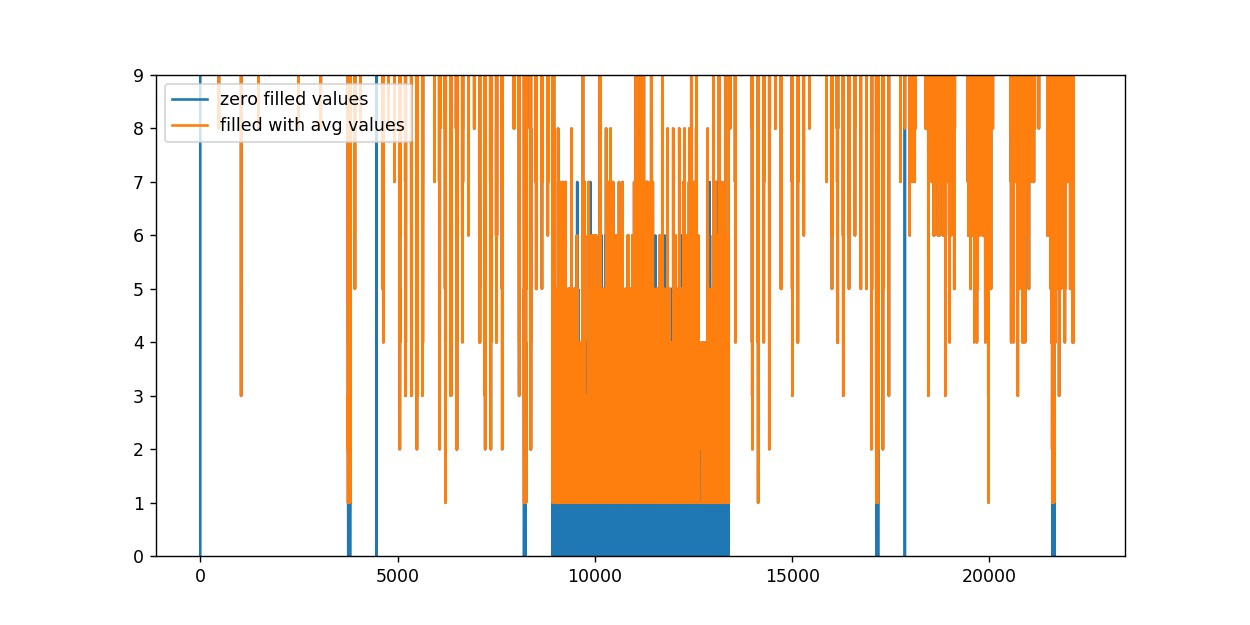

In [23]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464*25:8920*26], label="zero filled values")
plt.plot(jan_2015_smooth[4464*25:8920*26], label="filled with avg values")
plt.ylim(0,9)
plt.legend()
plt.show()

In [24]:
jan_2015_groupby = pd.read_pickle('./jan_2015_groupby')
jan_2016_groupby = pd.read_pickle('./jan_2016_groupby')
feb_2016_groupby = pd.read_pickle('./feb_2016_groupby')
mar_2016_groupby = pd.read_pickle('./mar_2016_groupby')

In [25]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 13104

In [26]:
pickle_out = open("jan_2015_smooth.pickle","wb")
pickle.dump(jan_2015_smooth, pickle_out)
pickle_out.close()

pickle_out = open("jan_2016_smooth.pickle","wb")
pickle.dump(jan_2016_smooth, pickle_out)
pickle_out.close()

pickle_out = open("feb_2016_smooth.pickle","wb")
pickle.dump(feb_2016_smooth, pickle_out)
pickle_out.close()

pickle_out = open("mar_2016_smooth.pickle","wb")
pickle.dump(mar_2016_smooth, pickle_out)
pickle_out.close()

In [5]:
pickle_in = open("jan_2015_smooth.pickle","rb")
jan_2015_smooth = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("jan_2016_smooth.pickle","rb")
jan_2016_smooth = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("feb_2016_smooth.pickle","rb")
feb_2016_smooth = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("mar_2016_smooth.pickle","rb")
mar_2016_smooth = pickle.load(pickle_in)
pickle_in.close()

In [7]:
regions_cum = []
for i in range(0,30):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

## Time series Fourier Transform

<IPython.core.display.Javascript object>


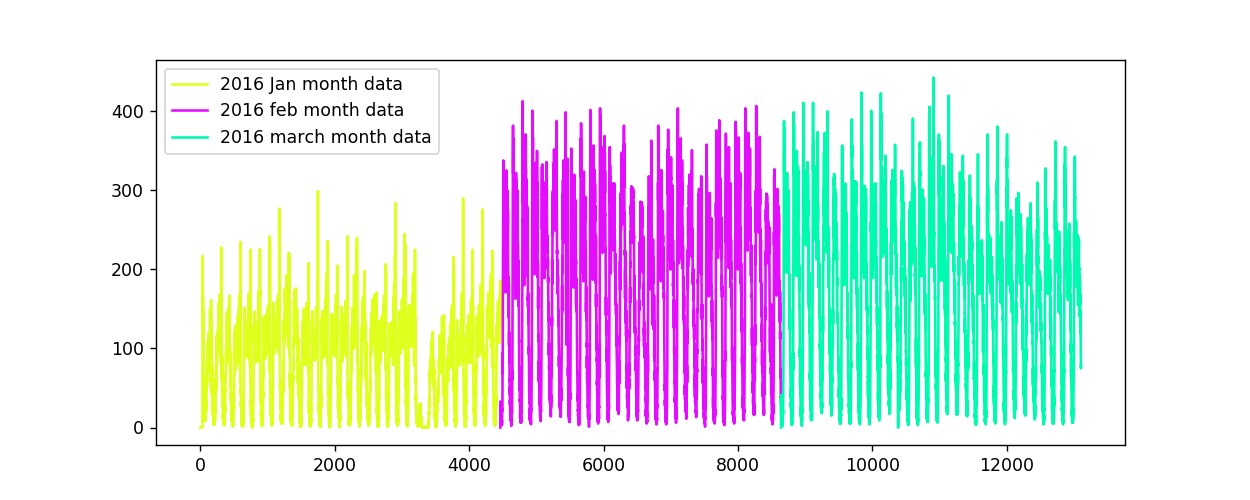

<IPython.core.display.Javascript object>


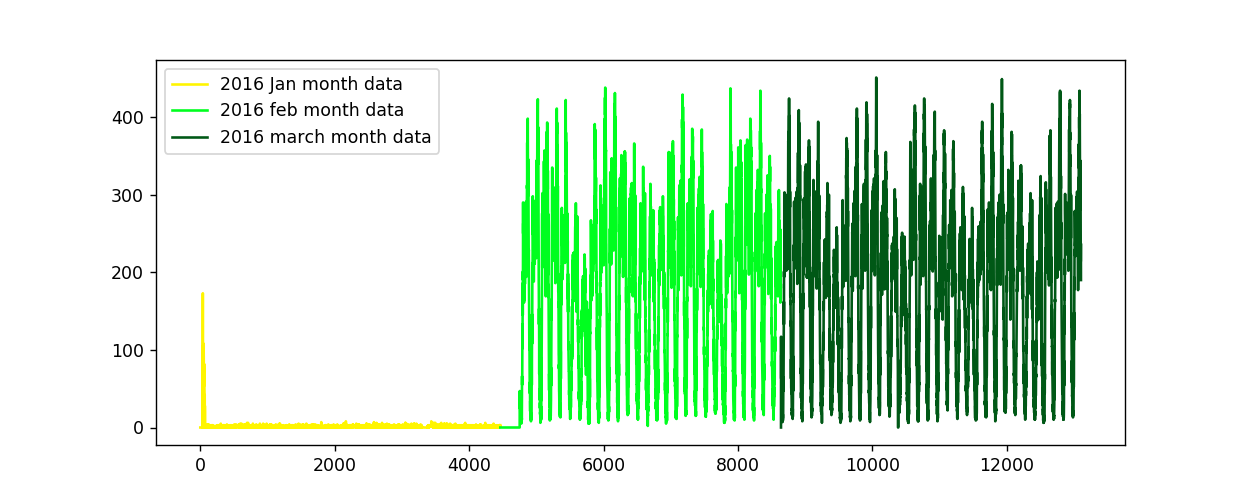

<IPython.core.display.Javascript object>


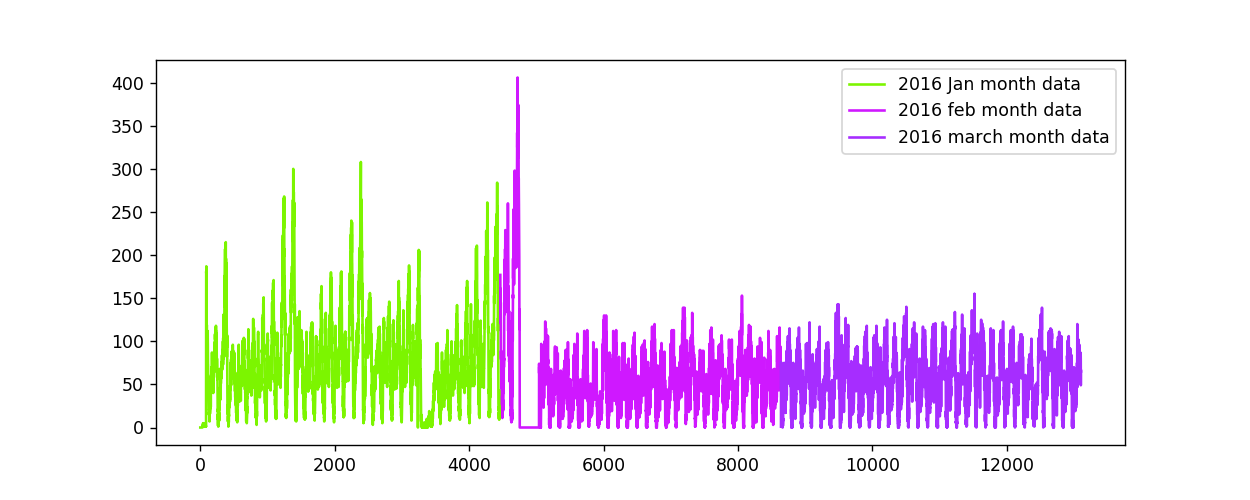

<IPython.core.display.Javascript object>


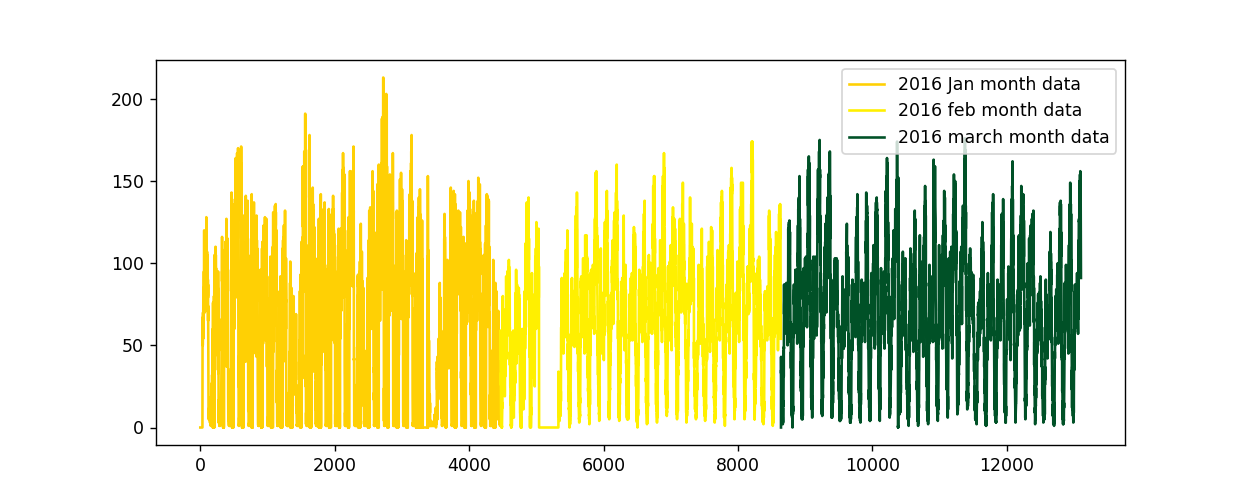

<IPython.core.display.Javascript object>


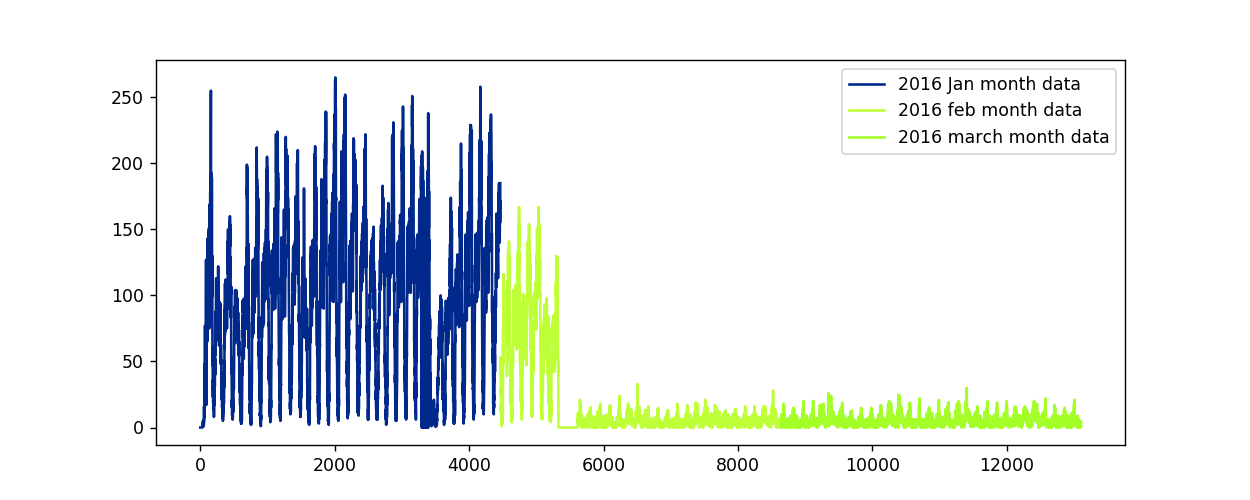

<IPython.core.display.Javascript object>


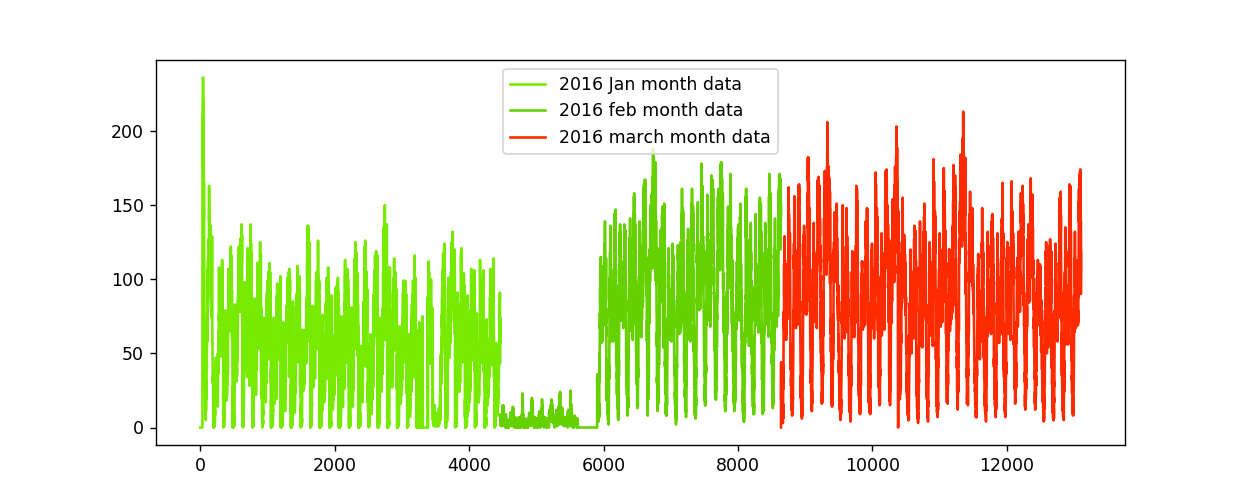

<IPython.core.display.Javascript object>


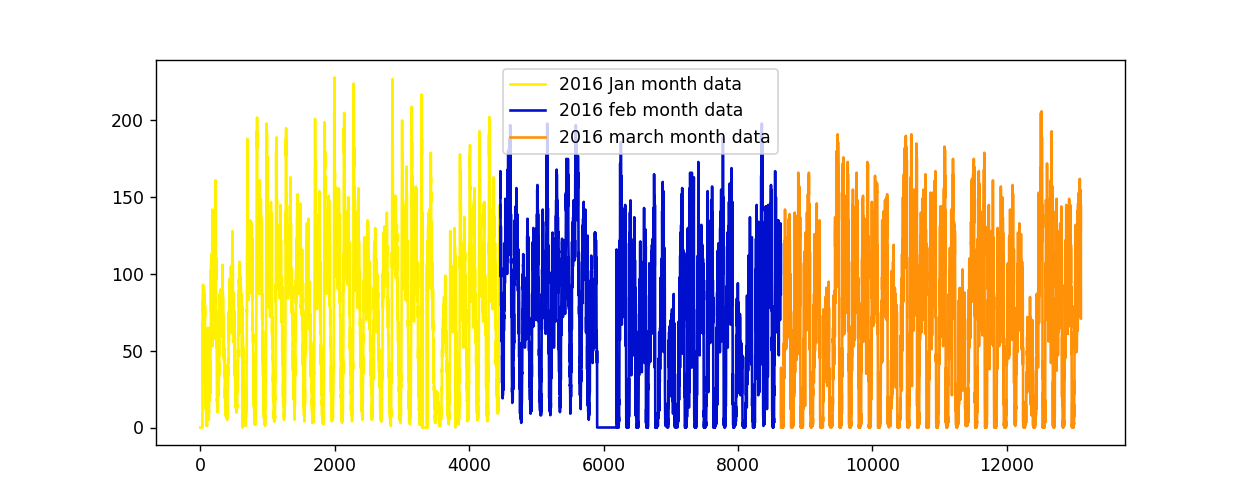

<IPython.core.display.Javascript object>


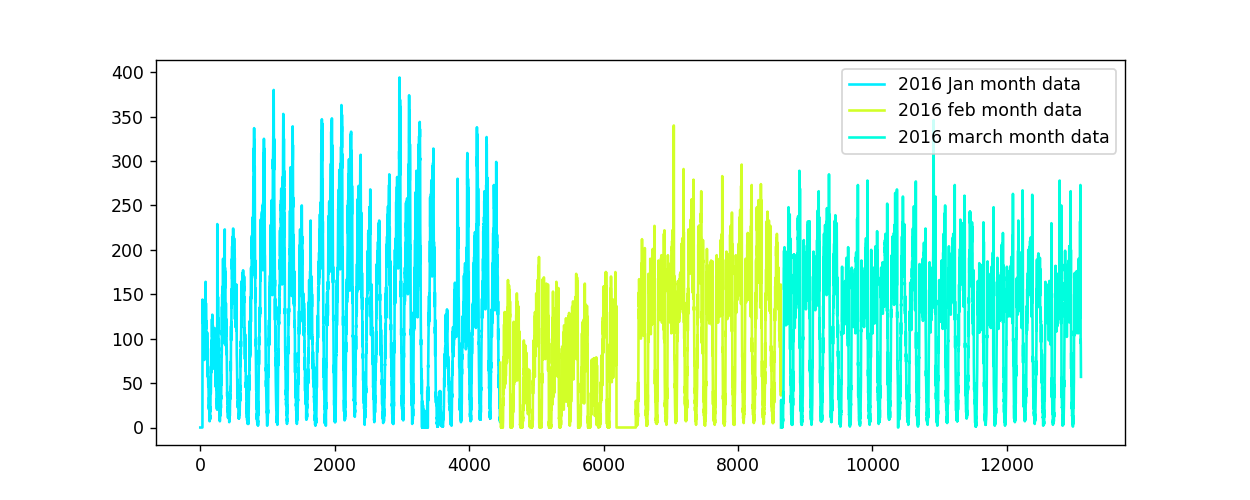

<IPython.core.display.Javascript object>


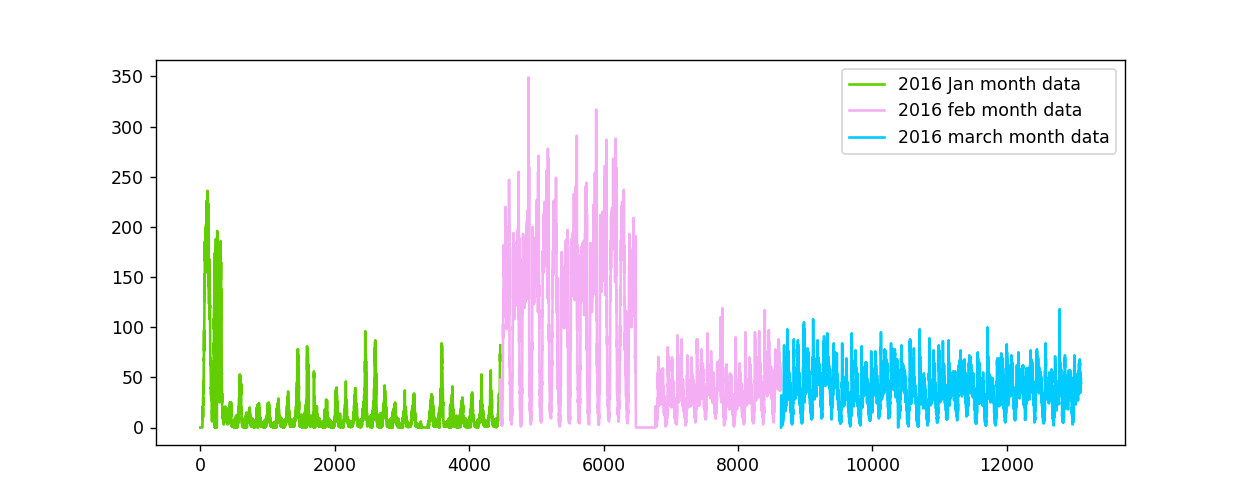

<IPython.core.display.Javascript object>


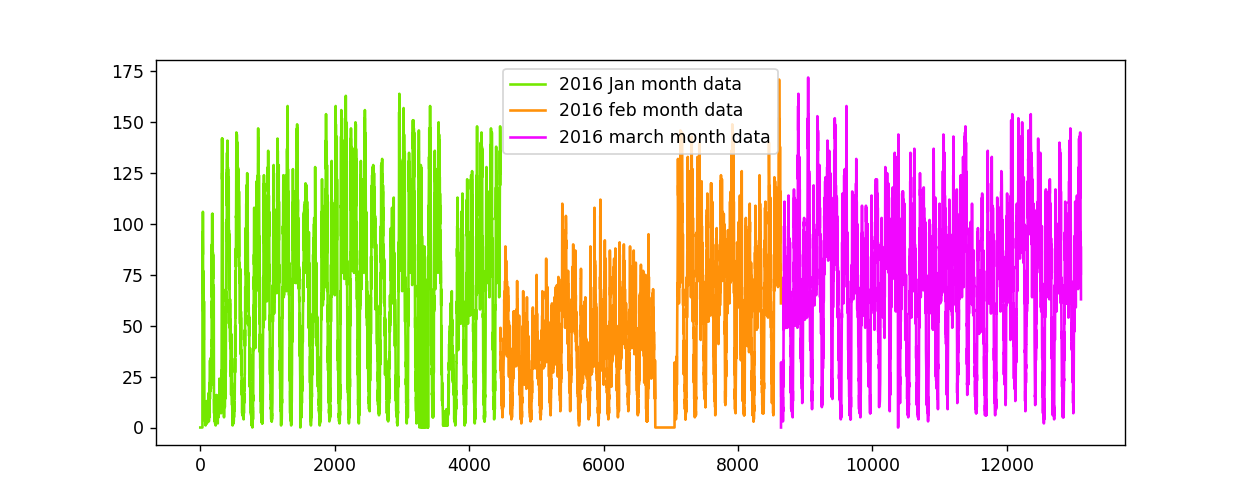

<IPython.core.display.Javascript object>


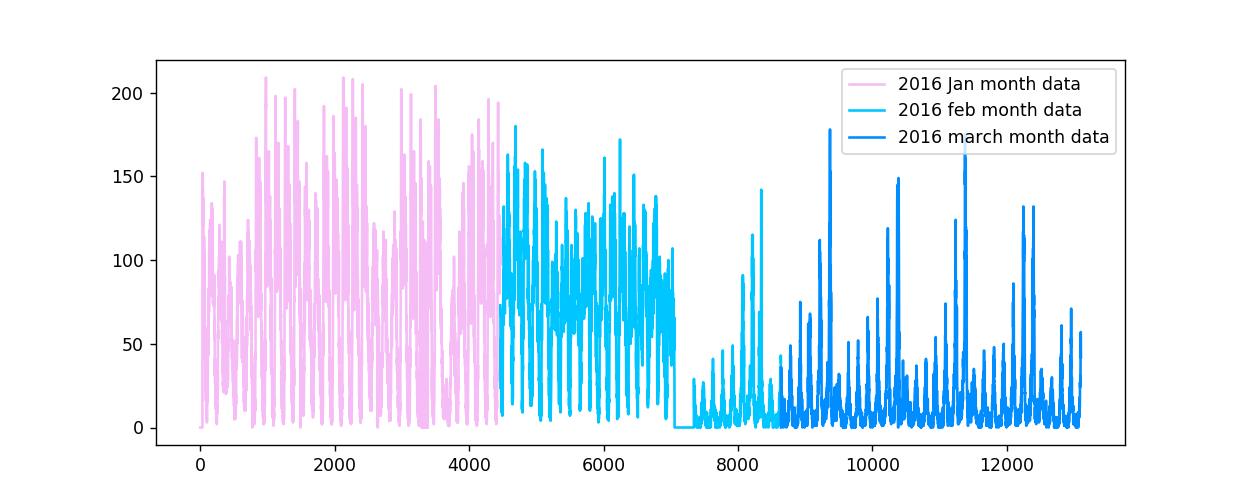

<IPython.core.display.Javascript object>


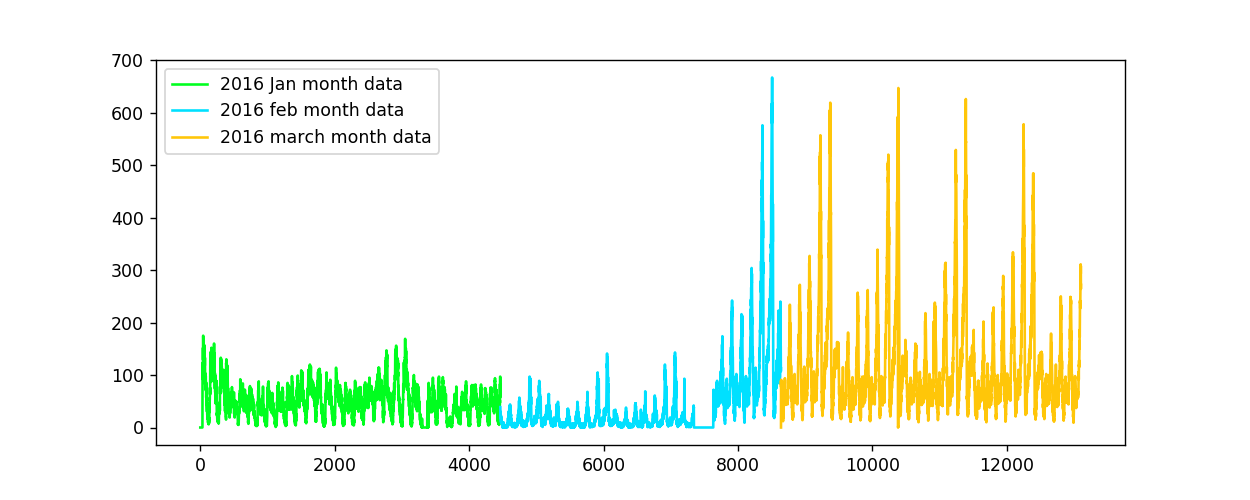

<IPython.core.display.Javascript object>


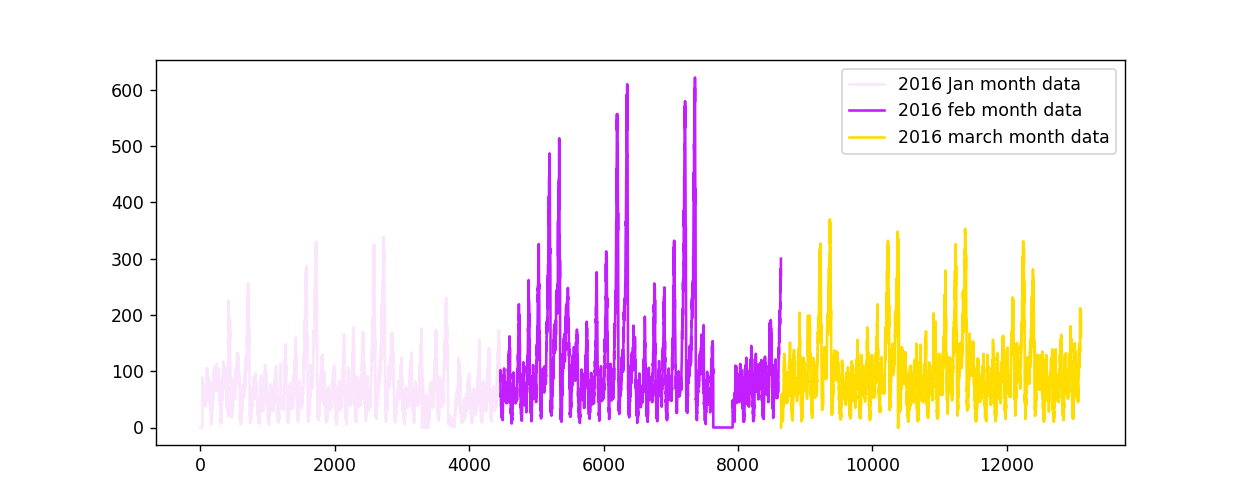

<IPython.core.display.Javascript object>


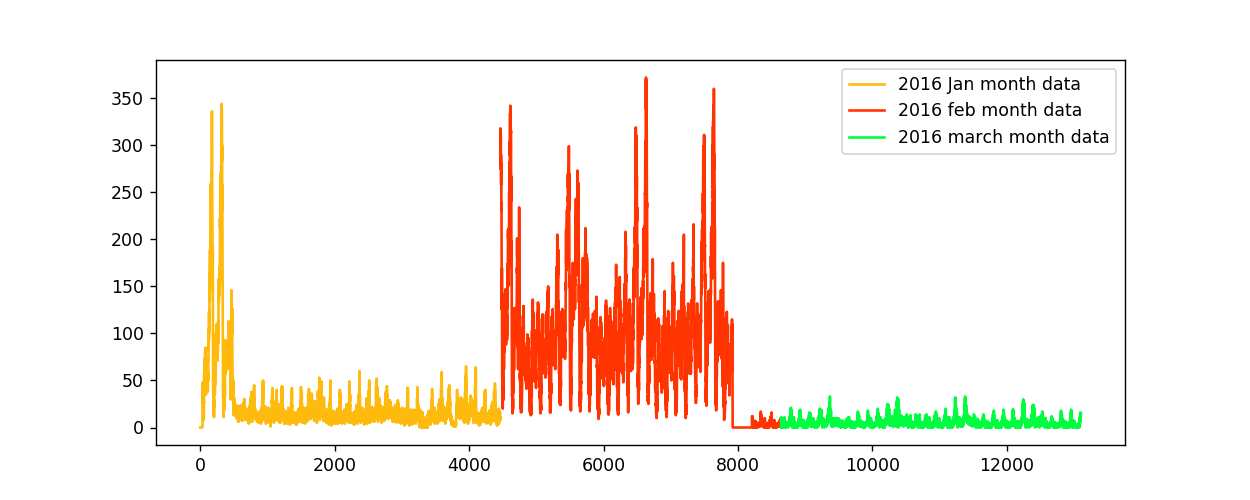

<IPython.core.display.Javascript object>


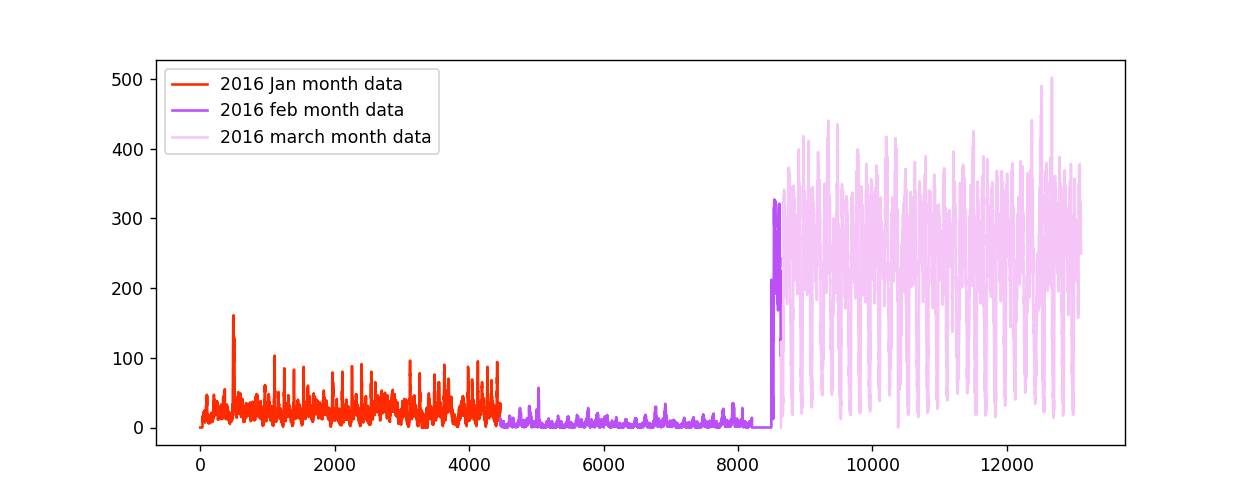

<IPython.core.display.Javascript object>


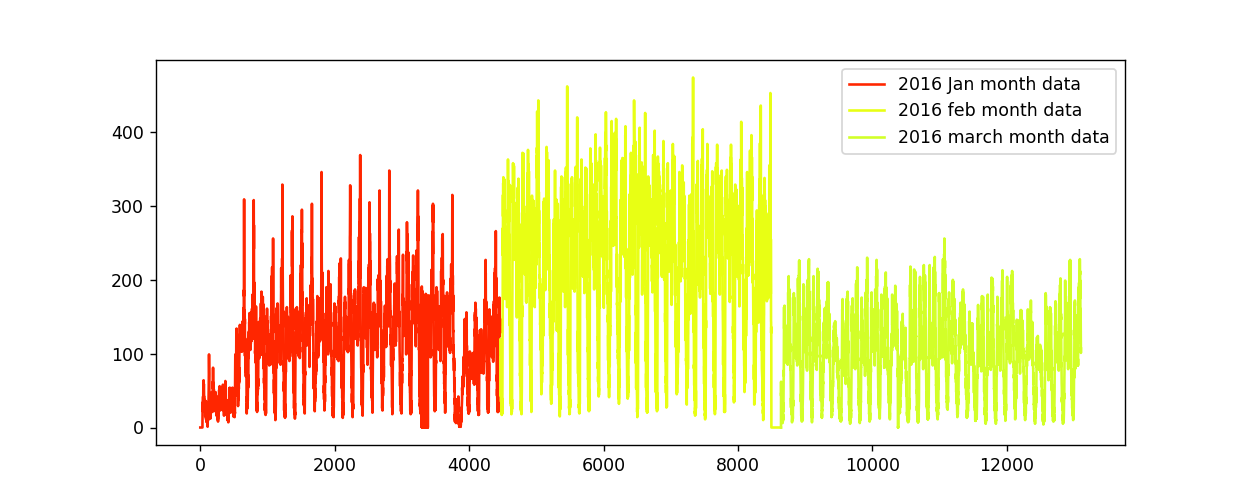

<IPython.core.display.Javascript object>


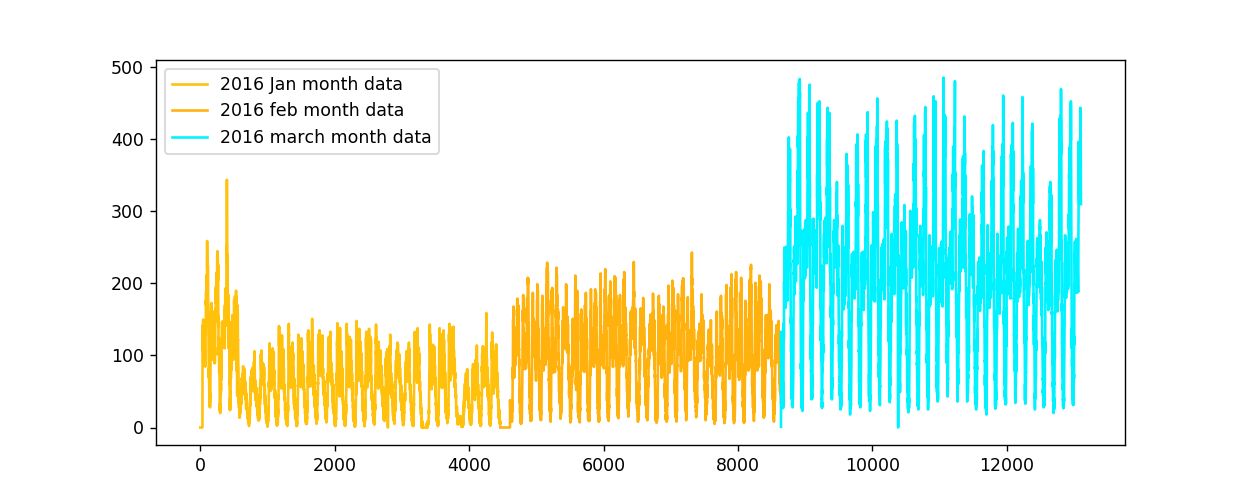

<IPython.core.display.Javascript object>


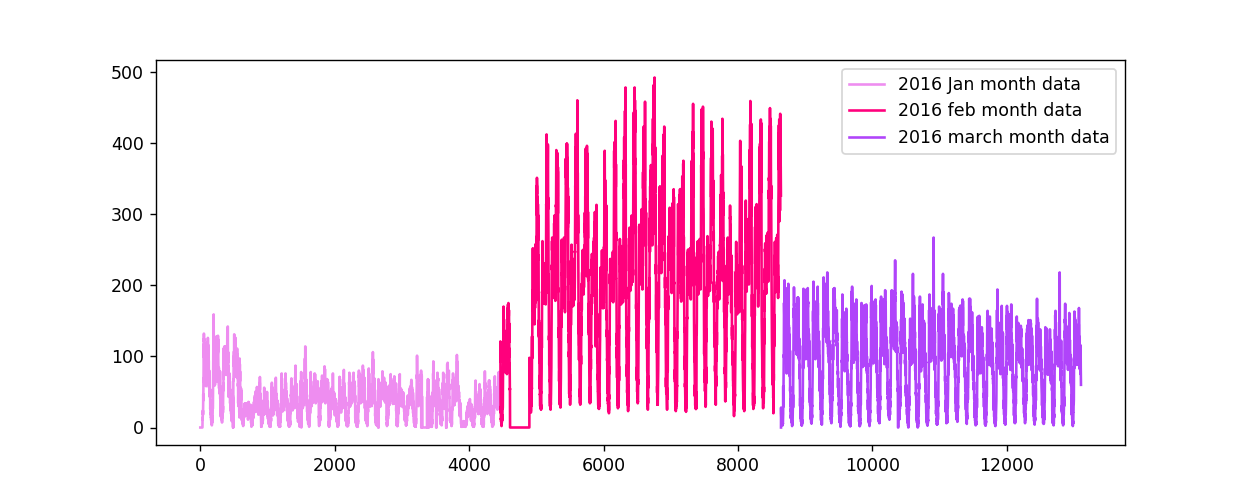

<IPython.core.display.Javascript object>


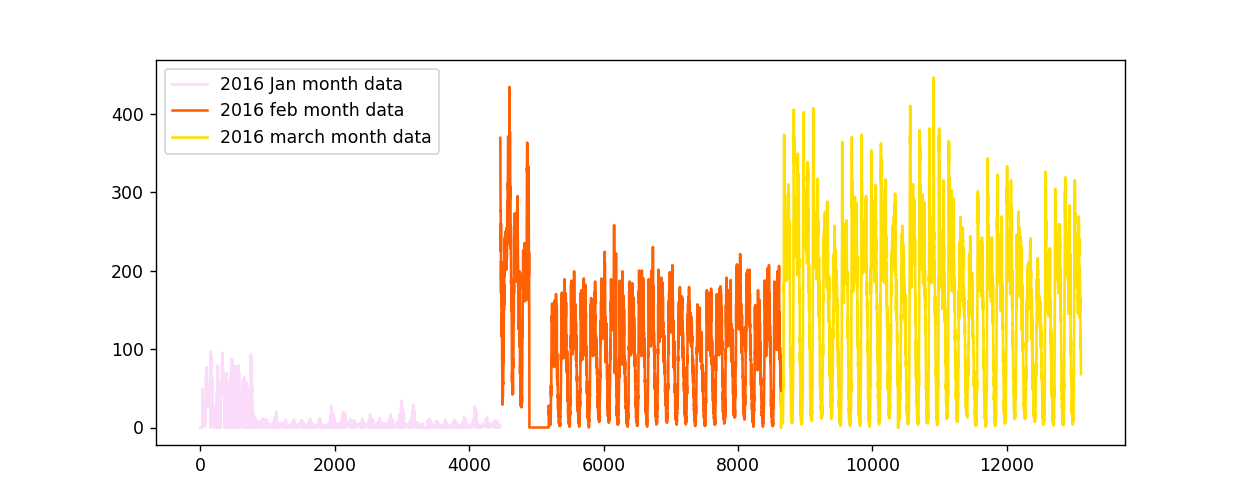

<IPython.core.display.Javascript object>


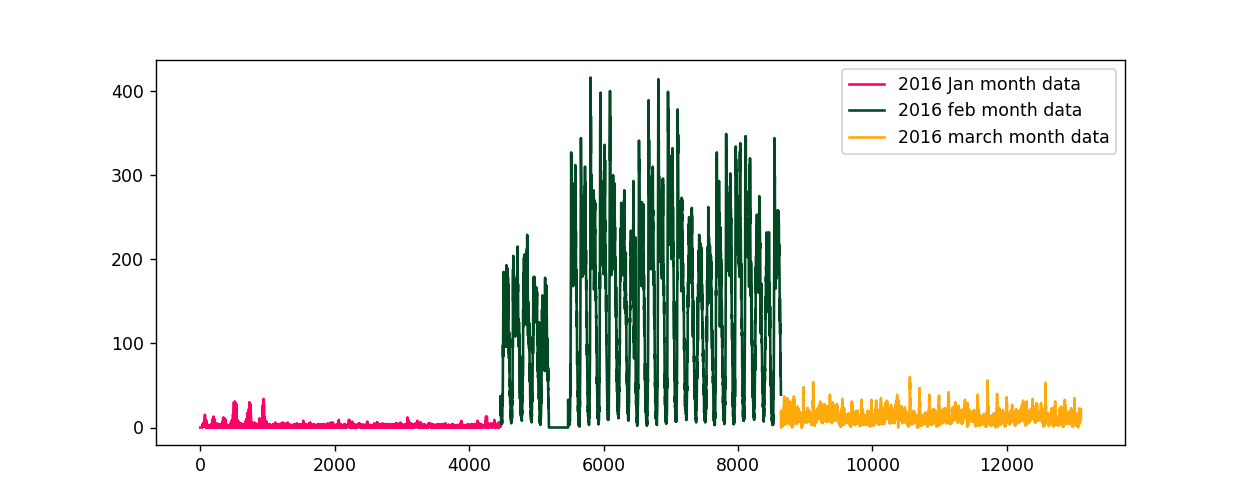

<IPython.core.display.Javascript object>


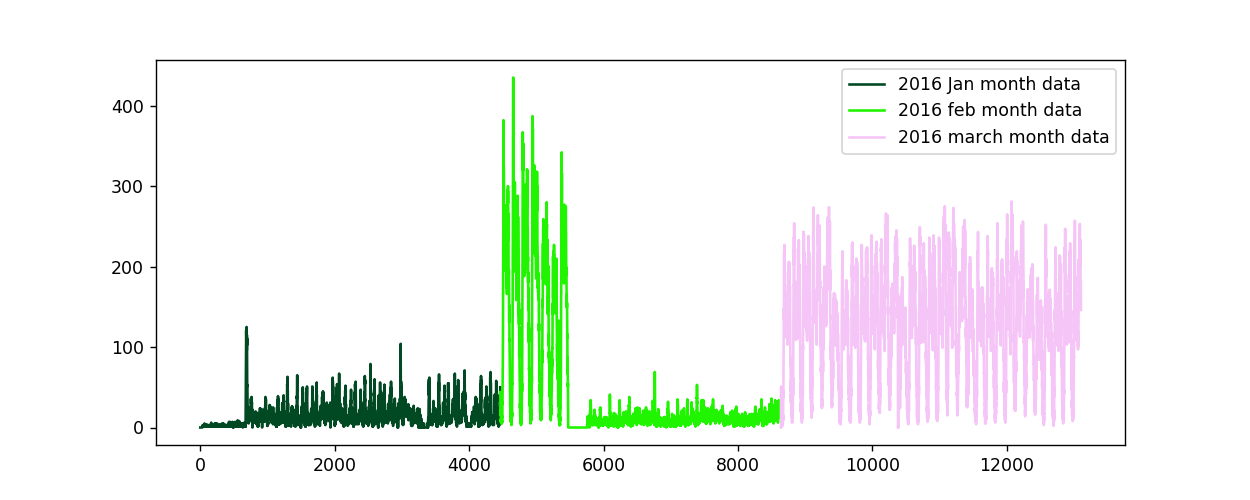

<IPython.core.display.Javascript object>


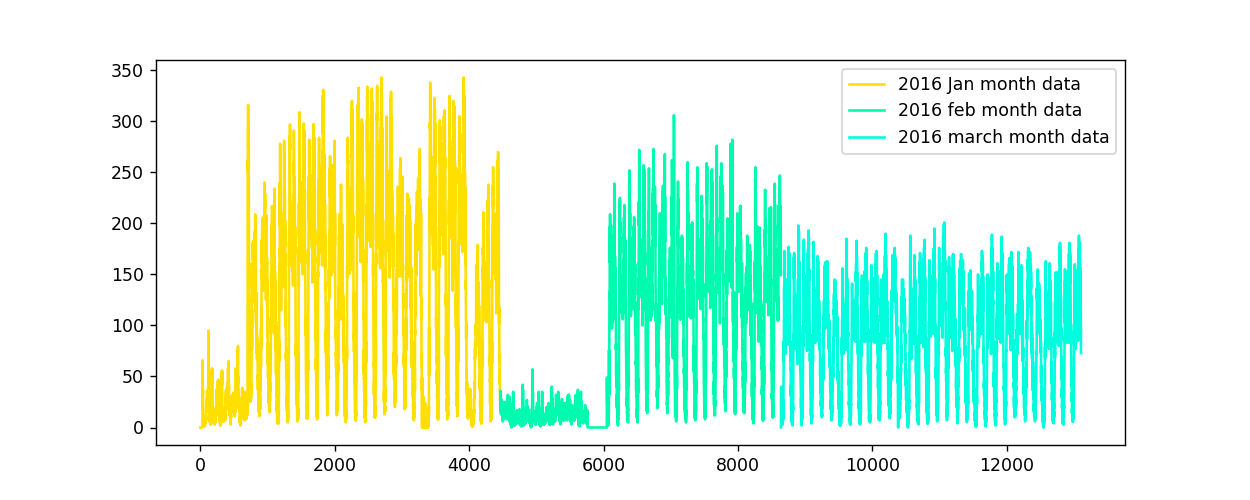

<IPython.core.display.Javascript object>


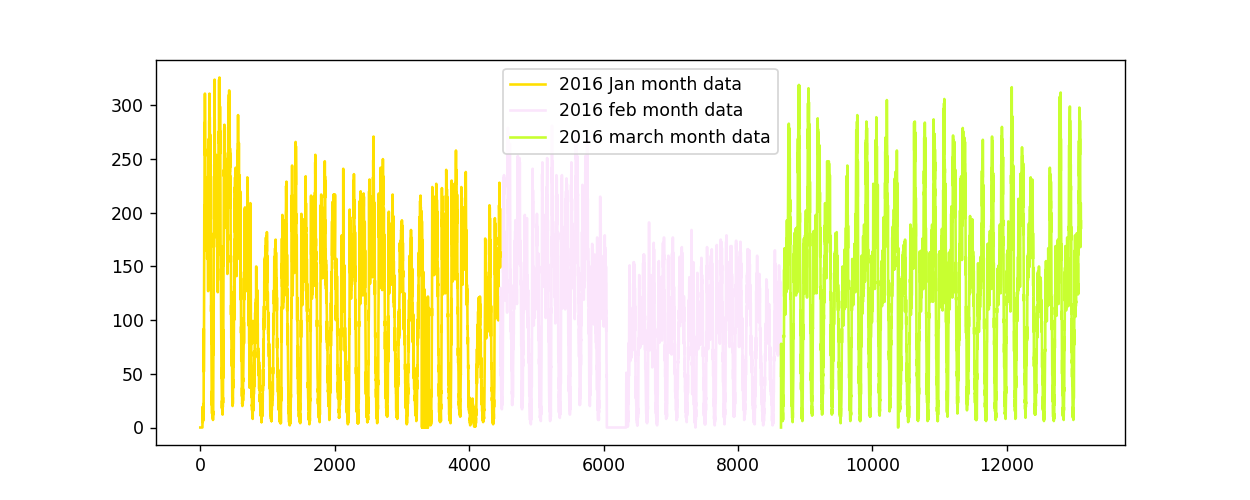

<IPython.core.display.Javascript object>


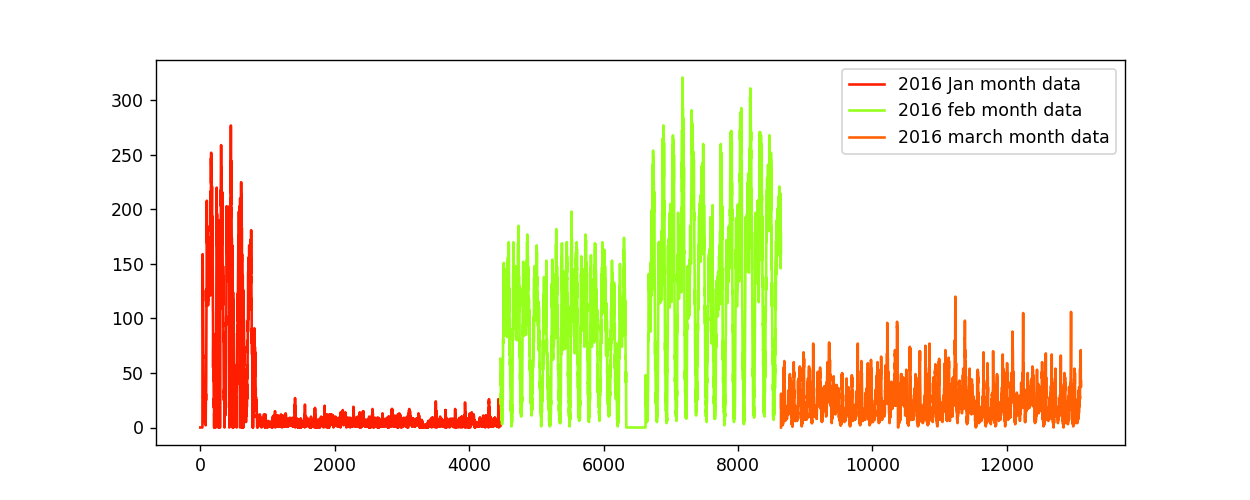

<IPython.core.display.Javascript object>


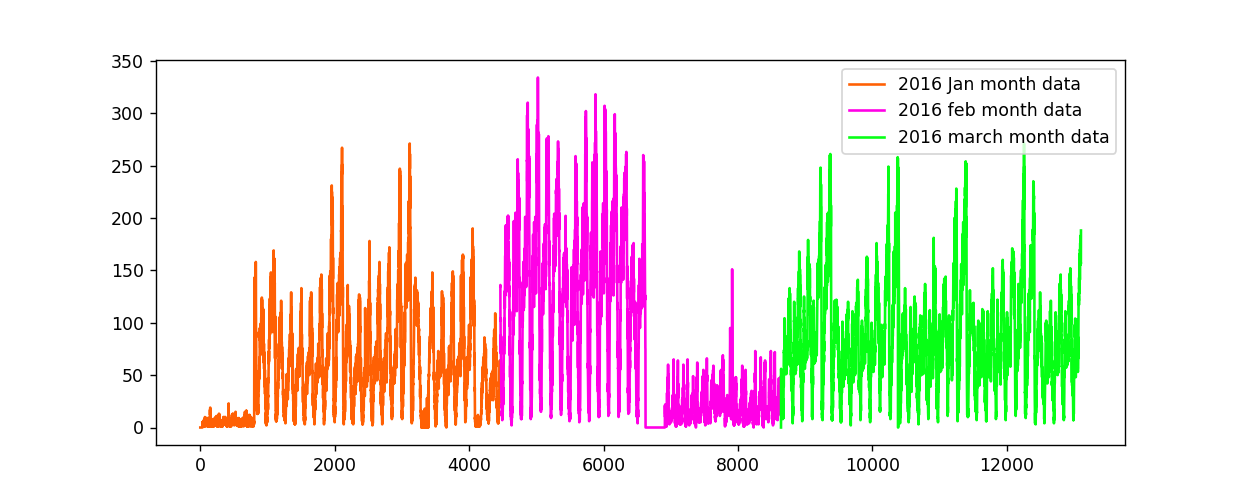

<IPython.core.display.Javascript object>


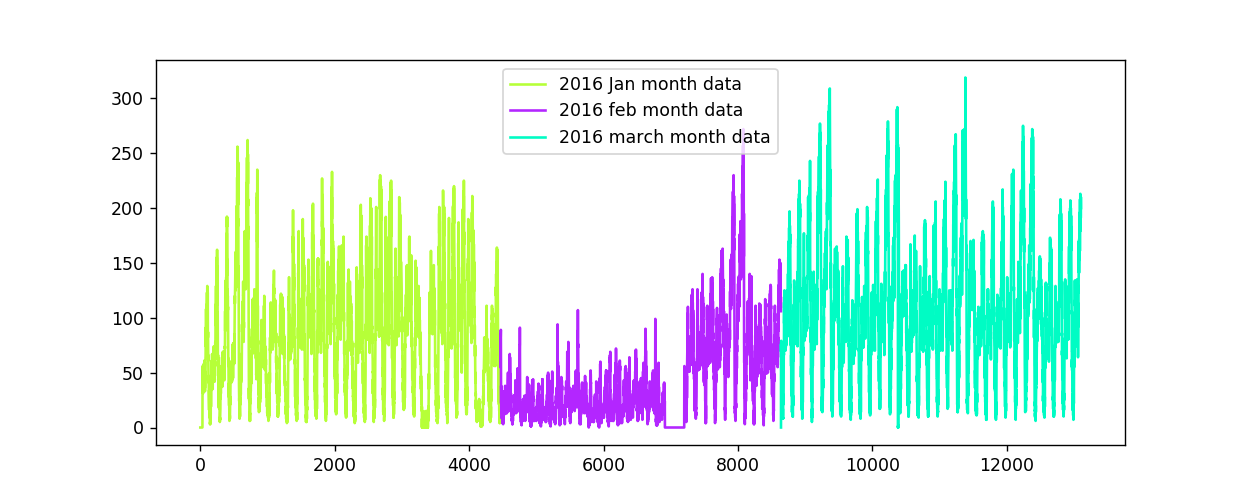

<IPython.core.display.Javascript object>


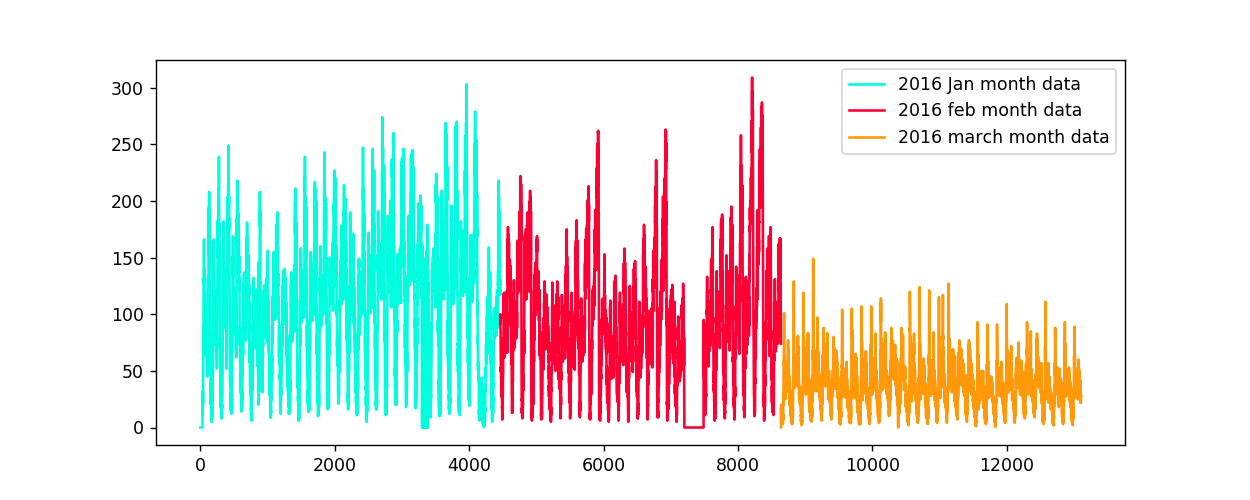

<IPython.core.display.Javascript object>


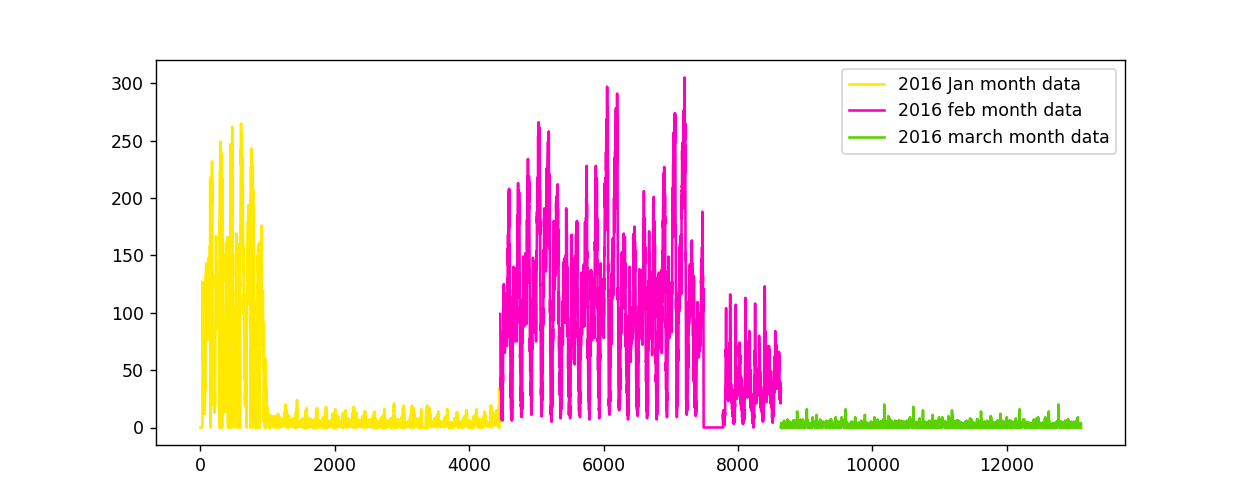

<IPython.core.display.Javascript object>


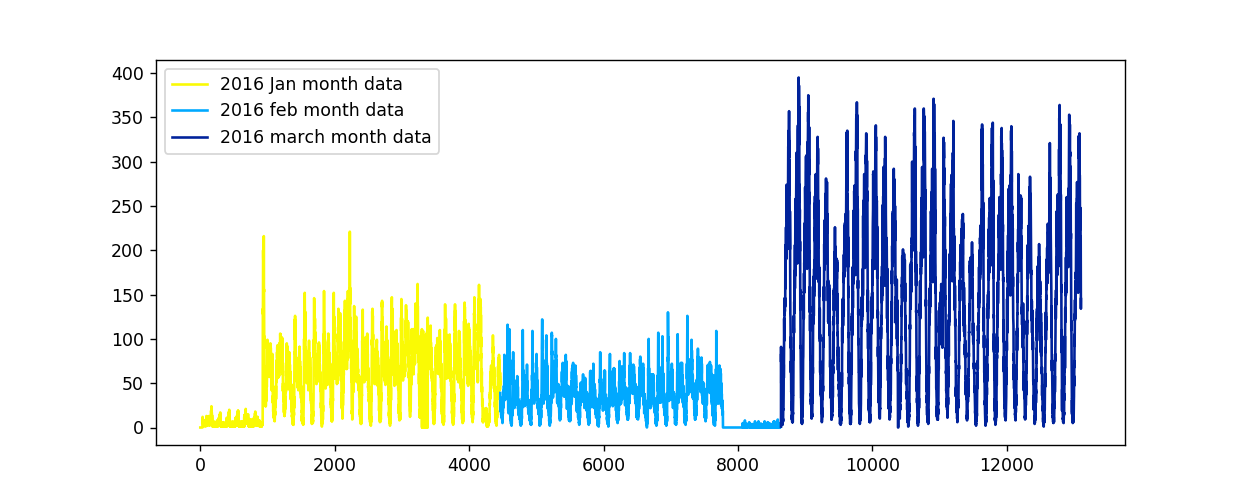

<IPython.core.display.Javascript object>


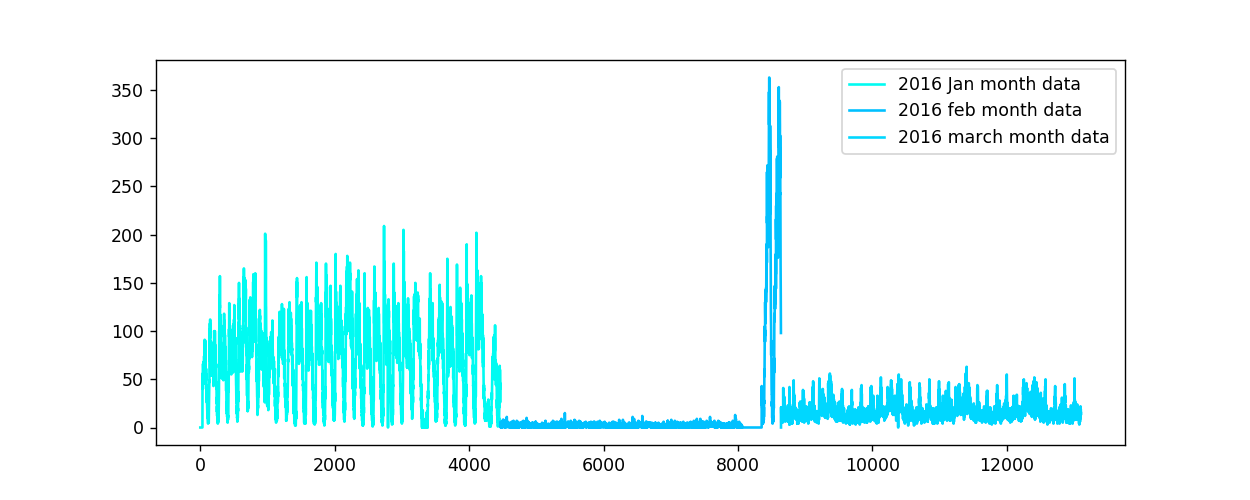

In [30]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(30):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


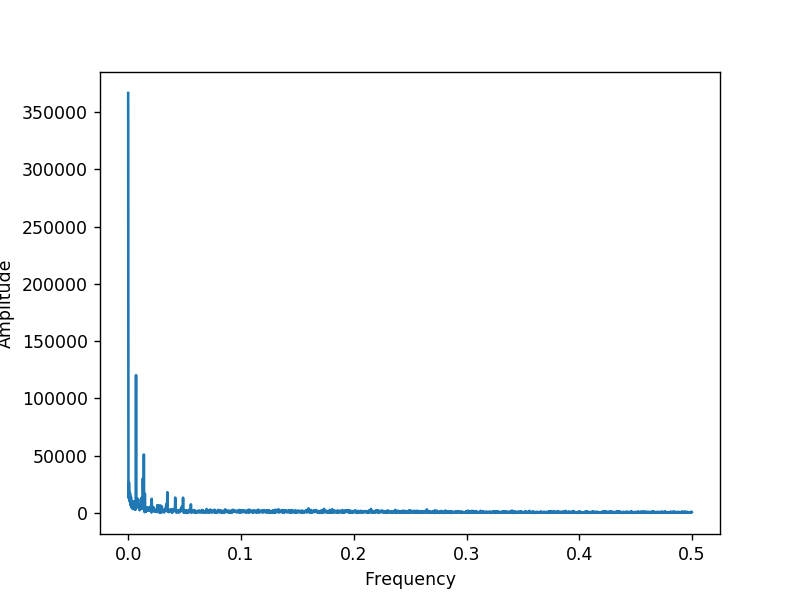

In [19]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

### Trying some peak amplitude features

In [20]:
# you can follow this website for more information --https://peakutils.readthedocs.io/en/latest/tutorial_a.html
import peakutils
from peakutils.plot import plot as pplot

def gets_peaks(amp_val1,t):
    '''returns incices of the peaks'''
    indices = peakutils.indexes(amp_val1, thres=t, min_dist=1,thres_abs=True)
    return indices

amp_val = np.abs(Y)
t1 = 10000 #threshold
ind = gets_peaks(amp_val,t1)

# plt.figure()
# pplot(freq, amp_val, ind)
# plt.title('peak estimate')
# plt.show() 

# print('extracted peaks \n',amp_val[ind])

In [1]:
# !pip3 install peakutils

In [21]:
def freqT(month_all):
    '''Discrete frequency transformation using fast fourier tranform'''
    '''Each cluster is transformed and processed separatly'''
    '''Returns top 5 amp and corresponding freq values for each cluster'''
    psd_y = []
    freq_x = []
    for clust_i in range(30):
        amp = np.fft.fft(month_all[i][:]) # returns complex values
        f = np.fft.fftfreq(1304,1)
        
        fre,ampli = process_freq(f,amp)
        
        t1=10000 # peak threshold
        peak_index = gets_peaks(ampli,t1)
        
        # sorting decending order , returns indices
        sorted_index = np.argsort(-(ampli[peak_index]))
        top5 = sorted_index[0:5]
        
        top5_amp = list(ampli[top5])
        top5_freq = list(fre[top5])
        
        psd_y.append(top5_amp)
        freq_x.append(top5_freq)
    return psd_y,freq_x

In [22]:
# 'psds' and 'frequencies' top 5 peak PSD values
# contains 30 lists corresponding to each cluster for 1st 3 months of 2016 data
# each of the 30 list is of size 5
def process_freq(freq,Y1):
    '''The Amplitude spectrum in frequency domian is a complex space
       so take absolute values of amplitude i.e PSD.
       
       The amplitude values are symmetric with y axis acting as the mirror so half of the 
       frequency space is sufficient to record all the frequency peaks'''
    n = len(freq) # x is freq
    
    f = np.abs(freq)[:int(n/2)]
    a = np.abs(Y1)[:int(n/2)]
    
    return f,a

psds,frequencies = freqT(regions_cum)

In [23]:
print('number of clusters',len(psds))
print('num of top values',len(psds[0]))

number of clusters 30
num of top values 5


# Modelling

In [37]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [38]:
print(ratios_jan.shape)
ratios_jan.head()

(133920, 3)


Given  Prediction  Ratios
0     69           0     0.0
1     69           0     0.0
2    262           0     0.0
3    311           0     0.0
4    326           0     0.0

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [40]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [41]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [42]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [43]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [44]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [45]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [47]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [48]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.30259650754268386       MSE:  1816.351336618877
Moving Averages (2016 Values) -                        MAPE:  0.151601053669964        MSE:  231.68163829151732
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.31093541475709624       MSE:  1942.1282332735962
Weighted Moving Averages (2016 Values) -               MAPE:  0.14388121249540275       MSE:  204.2053614097969
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.3185420632697434       MSE:  2084.987283452808
Exponential Moving Averages (2016 Values) -         MAPE:  0.143605535642

From the above matrix it is inferred that the best forecasting model for our prediction would be:- $\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

In [3]:
frame_with_durations_outliers_removed = pd.read_pickle('./frame_with_durations_outliers_removed')

In [4]:
coords = frame_with_durations_outliers_removed[['pickup_latitude','pickup_longitude']].values
Kmeans = MiniBatchKMeans(n_clusters=30,batch_size=10000,random_state=0).fit(coords)


In [8]:
# print(len(regions_cum))
# 30 i.e number of clusters/regions
# print(len(regions_cum[0])) 
# 13104 i.e number of bins for 3 months
 
previous_bins = 5 # number of previous 10min intravels to consider    
    
###########################################################################################
# The following variables will be used to store 30 lists
# each internal list will store 13104-5= 13099 values
# Ex: [[cluster0 13099times],[cluster1 13099times], [cluster2 13099times].... 30 lists]
###########################################################################################

output = [] # to store number of pickups 13104-5 = 13099 for each cluster

lat = [] # stores 13099 lattitude values for every cluster

lon = [] # stores 13099 longitude values for every cluster

weekday = [] # stores day coded as sun= 0, mon=1, tue= 2, wed=3, thur=4, fri=5, sat=6

##########################################################################################



# its an numpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th bin
# the second row will have [f1,f2,f3,f4,f5]
# and so on...
ts_feature = [0]*previous_bins

for i in range(0,30):
    lat.append([Kmeans.cluster_centers_[i][0]]*13099)
    lon.append([Kmeans.cluster_centers_[i][1]]*13099)
    
    # jan 1st 2016 is Friday, so we start our day from 5: "(int(k/144))%7+5"
    # prediction start from 5th bin using previous 5 bins
    
    weekday.append([(((k//144)%7)+5)%7 for k in range(5,4464+4176+4464)])
    
    # smooth16 is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 30 lsits]
    ts_feature = np.vstack((ts_feature, [regions_cum[i][r:r+previous_bins]\
                                             for r in range(0,len(regions_cum[i])-previous_bins)]))
    output.append(regions_cum[i][5:])
ts_feature = ts_feature[1:]

In [9]:
# sanity check
len(lat[0])*len(lat) == ts_feature.shape[0] == len(weekday)*len(weekday[0])== 30*13099 == len(output)*len(output[0])

True

In [10]:
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 30 lsits]
predict_list = []
flat_exp_avg = []
for r in range(0,30):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [24]:
print(len(psds))
print(len(frequencies))
print(len(psds[0]))

30
30
5


In [25]:
#frequencies and amplitudes are same for all the points a cluster
psd_feat = [0]*30
freq_feat = [0]*30

for cl in range(30):
    p_i = []
    f_i = []
    
    for k in range(13104):
        p_i.append(psds[cl])
        f_i.append(frequencies[cl])
    
    psd_feat[cl]=p_i
    freq_feat[cl]=f_i

### Train Test Split

Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [12]:
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


Last 5 pickups bin data

In [13]:
# Extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [ts_feature[i*13099:(13099*i+9169)] for i in range(0,30)]

test_features = [ts_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,30)]

In [14]:
print("Train data # Regions = ",len(train_features), \
      "\nNumber of data points", len(train_features[0]), \
      "\n Each data point contains", len(train_features[0][0]),"features\n")

print("Test data # Regions = ",len(train_features), \
      "\nNumber of data points in test data", len(test_features[0]), \
      "\nEach data point contains", len(test_features[0][0]),"features")

Train data # Regions =  30 
Number of data points 9169 
 Each data point contains 5 features

Test data # Regions =  30 
Number of data points in test data 3930 
Each data point contains 5 features


In [15]:
# the above contains values in the form of list of lists (i.e. list of values of each region),
# here we make all of them in one list
train_new_features = []
for i in range(0,30):
    train_new_features.extend(train_features[i])
    
test_new_features = []
for i in range(0,30):
    test_new_features.extend(test_features[i])

In [16]:
len(train_new_features)

275070

Fourier Transform features 9169 to train, 3930 to test

In [26]:
train_fourier_psd = [psd_feat[i][5:9169+5] for i in range(30)]
test_fourier_psd = [psd_feat[i][9169+5:] for i in range(30)]

In [27]:
len(test_fourier_psd[24])

3930

In [28]:
train_fourier_freq = [freq_feat[i][5:9169+5] for i in range(30)]
test_fourier_freq = [freq_feat[i][9169+5:] for i in range(30)]

In [29]:
# converting lists of lists into single list i.e flatten
train_psds = sum(train_fourier_psd, [])
test_psds  = sum(test_fourier_psd, [])

train_freqs = sum(train_fourier_freq, [])
test_freqs   = sum(test_fourier_freq, [])

In [30]:
len(train_psds)

275070

Cluster center Coordinates(lattitude and longitude) data

In [31]:
# 9169 to train

train_f_lat = [i[:9169] for i in lat]
train_f_lon = [i[:9169] for i in lon]
train_f_weekday = [i[:9169] for i in weekday]
train_f_output = [i[:9169] for i in output]
train_f_exp_avg = [i[:9169] for i in predict_list]

In [32]:
# 3930 points to test
test_f_lat = [i[9169:] for i in lat]
test_f_lon = [i[9169:] for i in lon]
test_f_weekday = [i[9169:] for i in weekday]
test_f_output = [i[9169:] for i in output]
test_f_exp_avg = [i[9169:] for i in predict_list]

In [33]:

# converting lists of lists into single list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

train_lat = sum(train_f_lat, [])
train_lon = sum(train_f_lon, [])
train_weekday = sum(train_f_weekday, [])
train_output = sum(train_f_output, [])
train_exp_avg = sum(train_f_exp_avg,[])

In [38]:
# converting lists of lists into sinle list i.e flatten

test_lat = sum(test_f_lat, [])
test_lon = sum(test_f_lon, [])
test_weekday = sum(test_f_weekday, [])
test_output = sum(test_f_output, [])
test_exp_avg = sum(test_f_exp_avg, [])


### Preparing the data frame for our train data

In [34]:
train_FT = np.hstack((train_new_features, train_psds, train_freqs))
test_FT = np.hstack((test_new_features, test_psds,test_freqs))

In [36]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1','P1','P2','P3','P4','P5',\
           'freq1','freq2','freq3','freq4','freq5']

data_train = pd.DataFrame(data=train_FT, columns=columns) 
data_train['lat'] = train_lat
data_train['lon'] = train_lon
data_train['weekday'] = train_weekday
data_train['exp_avg'] = train_exp_avg


print(data_train.shape)

(275070, 19)


### Preparing the data frame for our test data

In [39]:
data_test = pd.DataFrame(data=test_FT, columns=columns) 
data_test['lat'] = test_lat
data_test['lon'] = test_lon
data_test['weekday'] = test_weekday
data_test['exp_avg'] = test_exp_avg
print(data_test.shape)

(117900, 19)


In [40]:
pickle_out = open("data_train.pickle","wb")
pickle.dump(data_train, pickle_out)
pickle_out.close()

pickle_out = open("data_test.pickle","wb")
pickle.dump(data_test, pickle_out)
pickle_out.close()

pickle_out = open("train_output.pickle","wb")
pickle.dump(train_output, pickle_out)
pickle_out.close()

pickle_out = open("test_output.pickle","wb")
pickle.dump(test_output, pickle_out)
pickle_out.close()

In [75]:
# Base Line Model MAPE
train_b_mape=(mean_absolute_error(train_output,data_train['ft_1'].values))/(sum(train_output)/len(train_output))
train_e_mape=(mean_absolute_error(train_output,data_train['exp_avg'].values))/(sum(train_output)/len(train_output))

# Exponential Averages Forecasting MAPE
test_b_mape= (mean_absolute_error(test_output, data_test['ft_1'].values))/(sum(test_output)/len(test_output))
test_e_mape= (mean_absolute_error(test_output, data_test['exp_avg'].values))/(sum(test_output)/len(test_output))

In [76]:
print("Baseline Model Train mape error is {} and Test mape error is {}".format(train_b_mape,test_b_mape))

Baseline Model Train mape error is 0.13469627211834073 and Test mape error is 0.12137217161272074


In [77]:
print("Exponential Moving average Model Train mape error is {} and Test mape error is {}".format(train_e_mape,test_e_mape))

Exponential Moving average Model Train mape error is 0.1287163831395446 and Test mape error is 0.11613179453264473


# Regression Models

### Using Linear Regression

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_standard = scaler.fit_transform(data_train)
data_test_standard = scaler.transform(data_test)

In [53]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV


start = datetime.datetime.now()
lr = SGDRegressor(loss='squared_loss')
alpha = [0.00001,0.000001,0.000002,0.000005]
iteration = [300,400,500,600]

c_param = {"alpha": alpha, "max_iter":iteration}
optimal_model = GridSearchCV(lr, param_grid= c_param, scoring = "neg_mean_absolute_error",n_jobs=4, cv=3)

optimal_model.fit(data_train_standard, train_output)
print(datetime.datetime.now() - start)

0:07:07.867762


In [56]:
y_pred =  optimal_model.best_estimator_.predict(data_train_standard)
lr_train_predictions = [round(value) for value in y_pred]

y_pred = optimal_model.best_estimator_.predict(data_test_standard)
lr_test_predictions = [round(value) for value in y_pred]

print(optimal_model.best_params_)

{'alpha': 5e-06, 'max_iter': 300}


In [66]:
train_lr_mape= (mean_absolute_error(train_output, lr_train_predictions))/(sum(train_output)/len(train_output))
test_lr_mape= (mean_absolute_error(test_output, lr_test_predictions))/(sum(test_output)/len(test_output))

print(train_lr_mape)
print(test_lr_mape)

0.1291757158762774
0.11576327750784628


## Using Random Forest Regressor

In [64]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

n_estimator = sp_randint(300,600)
max_depth = sp_randint(10, 20)
min_split = sp_randint(8, 15)
start = [False]
min_leaf = sp_randint(8, 15)
c_param = {'n_estimators':n_estimator ,'max_depth': max_depth,'min_samples_split':min_split,\
           'min_samples_leaf':min_leaf ,'warm_start':start }

RandomForest = RandomForestRegressor(max_features='sqrt', n_jobs=4)

optimal_model2 =  RandomizedSearchCV(RandomForest, param_distributions= c_param, scoring = "neg_mean_absolute_error",n_jobs=4, cv=3)

optimal_model2.fit(data_train, train_output)

y_pred = optimal_model2.best_estimator_.predict(data_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = optimal_model2.best_estimator_.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]
print(optimal_model2.best_params_)

{'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 13, 'n_estimators': 445, 'warm_start': False}


In [65]:
train_rf_mape=(mean_absolute_error(train_output,rndf_train_predictions))/(sum(train_output)/len(train_output))
test_rf_mape= (mean_absolute_error(test_output, rndf_test_predictions))/(sum(test_output)/len(test_output))
print(train_rf_mape)
print(test_rf_mape)

0.12245511802317784
0.11464759603805973


## Using Xgboost Regressor

In [68]:
import xgboost as xgb
from scipy import stats

c_param={'learning_rate' :stats.uniform(0.01,0.2),
  'n_estimators':sp_randint(100,1000),
  'max_depth':sp_randint(1,10),
  'min_child_weight':sp_randint(1,8),
  'gamma':stats.uniform(0,0.02),
  'subsample':stats.uniform(0.6,0.4),
  'reg_alpha':sp_randint(0,200),
  'reg_lambda':stats.uniform(0,200),
  'colsample_bytree':stats.uniform(0.6,0.3)}

XgbReg= xgb.XGBRegressor(nthread = 4)
optimal_model3 = RandomizedSearchCV(XgbReg, param_distributions= c_param, scoring = "neg_mean_absolute_error", cv = 3)

optimal_model3.fit(data_train, train_output)

y_pred = optimal_model3.predict(data_train)
xgb_train_predictions = [round(value) for value in y_pred]
y_pred = optimal_model3.predict(data_test)
xgb_test_predictions = [round(value) for value in y_pred]

print(optimal_model3.best_params_)

{'colsample_bytree': 0.6420662785546201, 'gamma': 0.007150321722188182, 'learning_rate': 0.034101062236619475, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 833, 'reg_alpha': 118, 'reg_lambda': 129.18792417062514, 'subsample': 0.6938340153657678}


In [69]:
train_xgb_mape=(mean_absolute_error(train_output, xgb_train_predictions))/(sum(train_output)/len(train_output))
test_xgb_mape= (mean_absolute_error(test_output, xgb_test_predictions))/(sum(test_output)/len(test_output))
print(train_xgb_mape)
print(test_xgb_mape)

0.12408885283815188
0.11410007683809335


# Conclusion

### Comparison of various models error metric

In [74]:
from prettytable import PrettyTable

In [78]:
x = PrettyTable()
x.title = 'Model error metric comparisson'
x.field_names = ['Model','Train mape','Test mape']
x.add_row(['BaseLine Model',0.1346,0.1213])
x.add_row(['Expontential Moving Average',0.1287,0.1161])
x.add_row(['Linear Regression',0.1291,0.1157])
x.add_row(['Random Forest Regressor',0.1224,0.1146])
x.add_row(['XgBoost',0.1240,0.1141])
print(x)

+-----------------------------+------------+-----------+
|            Model            | Train mape | Test mape |
+-----------------------------+------------+-----------+
|        BaseLine Model       |   0.1346   |   0.1213  |
| Expontential Moving Average |   0.1287   |   0.1161  |
|      Linear Regression      |   0.1291   |   0.1157  |
|   Random Forest Regressor   |   0.1224   |   0.1146  |
|           XgBoost           |   0.124    |   0.1141  |
+-----------------------------+------------+-----------+


> As we have achieved error less then 12%

> Hence tree based model performed very well as we can see we got better performance with XgBoost Regressor

## Steps Followed :

In [ ]:
 1. Step 1- Data cleaning , removing outlier based on features we needed
 2. Step 2- We segmented the region acc to pickups based on long and latitude using clustering
 3. Step 3- We tried baseline model on our data from jan 2015 and jan 2016 and got MAPE for various model and compared which one is better
 4. Step 4- We took top 5 features and performed feature engineering like amplitutde .
 5. Step 5- We tried various regression model like Linear , RandomForest and XgBoost Regressor.
    